Matthieu Antony, in AEDES, developed an algorithm to orient the program's supervision. This algorithm works in six steps :

1. Computation of aggregate level of payment diminution for each indicator
2. Determination of a subset of N indicators that cause most of payment diminutions
3. Computation of a weighted correction rate of these indicators for each facility, using a priori weights displaying the qualitative interest of each activity
4. Classification of facilities in three levels of risks, based on their weighted correction rates and correction amounts, and predefined threshold
7. Monthly sampling of each facilities, with different sampling probabilities depending on facilities class

In [37]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


from IPython.display import set_matplotlib_formats
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"


# For warnings
import warnings
warnings.filterwarnings('ignore')

store = pd.HDFStore('../../data/processed/orbf_benin.h5')
tarifs = store['tarifs']
data = store['data']
store.close()

## Replication of the hand results

First I want to replicate the results Matthieu obtained by Manually processing the data in Excel. First I want to subset the data to the data reported by the WB Zones de Santé for the year 2016, and dropping all data collected after november 2016.

In [2]:
bm_zones =['OUIDAH-KPOMASSE-TORI-BOSSITO', 'BANIKOARA', 'LOKOSSA-ATHIEME' , 'ADJOHOUN-BONOU-DANGBO' ,
           'KOUANDE-OUASSA-PEHUNCO-KEROU','COVE-ZANGNANADO-OUINHI', 'PORTONOVO-AGUEGUES-SEME-PODJI', 
           'BOHICON-ZAKPOTA-ZOGBODOMEY']

data = data[data.period.apply(str).str[0:4] == '2016']
data = data[data.date < '2016-11']

data_test = data[data.geozone_name.isin(bm_zones)]

data_test = data_test.set_index('indicator_label')

### Indicators ranking and subsetting

The first step of the algorithm is to rank the indicators according to their importance in term of financial risk for the program. We want to evaluate the risk of each indicator in term of unduly claimed payments from the program. 

Let's $P_{ift}^c$ be the claimed payment of facility $f$ at time $t$ for the indicator $i$ and $P_{ift}^v$ the verified payment of this facility for this period for this indicator.

The ranking algorithm runs in three steps :

1. Computing the difference between claimed payment and verified payment :
$$ \Delta_{if} = \sum_t P_{ift}^c - P_{ift}^v$$
And $\Delta_{if}$ will be positive if the payment was lowered, and negative if the payment was made higher after verification.
Aggregated at program level, this difference is denoted $\Delta_{i} = \sum_{f,t} P_{ift}^c - P_{ift}$

2. Computing the share of the financial risk that a given indicator holds for the program, computed as 
$$r_i = \frac{\Delta_i}{\sum_i \Delta_i}$$

3. Finally, the indicators are ranked according in decreasing importance of their share in financial risk, and the progressive cumulative sum of this share is computed.  The first indicators of these ranking are considered critical, to keep indicators representing around 80\% of the total risk  

In [3]:
## Making payment claimed and verified

data_test['claimed_payment'] = list(data_test.indicator_claimed_value * data_test['indicator_tarif'])
data_test['verified_payment'] = list(data_test.indicator_verified_value * data_test['indicator_tarif'])

## Getting total amount of money the program got back 
def get_ecarts(data):
    return sum(data['indicator_claimed_value'] - data['indicator_verified_value']) / sum(data['indicator_claimed_value'])

def get_revenu_gagne(data):
    return sum(data['indicator_montant'])

def get_volume_financier_recupere(data) :
    return sum(data['claimed_payment'] - data['verified_payment'])

def make_first_table(data):
    col1 = data.groupby(level = 0).apply(get_ecarts)
    col2 = data.groupby(level = 0).apply(get_revenu_gagne)
    col3 = data.groupby(level = 0).apply(get_volume_financier_recupere)
    col4 = col3 / get_volume_financier_recupere(data)
    
    
    output = col1.to_frame()
    output.columns = ['Ecarts']
    output['Revenus Totaux Gagnés'] = col2
    output['Volume Financier Récupéré'] = col3
    output['% Volume Financier Récupéré'] = col4
   
    output = output.sort_values('% Volume Financier Récupéré' , ascending = False)
    output['% Cumulé'] = output['% Volume Financier Récupéré'].cumsum()
    return output


table_1 = make_first_table(data_test)
table_1

,Ecarts,Revenus Totaux Gagnés,Volume Financier Récupéré,% Volume Financier Récupéré,% Cumulé
indicator_label,,,,,
Enfants completement vaccines,0.054820,171777000.0,9963000.0,0.148810,0.148810
"CPN 1 standard (y compris VAT, MILD et supplémentation en micronutriments)",0.072376,113312500.0,8841000.0,0.132051,0.280861
Accouchement eutocique assiste,0.024216,315502500.0,7837500.0,0.117063,0.397924
Consultation postnatale 1 (du 7ème au 10ème jour),0.063491,84150500.0,5705000.0,0.085211,0.483136
Diagnostic et traitement des cas de paludisme sévère chez les enfants,0.143090,31004960.0,5177310.0,0.077330,0.560465
Consultation prenatale quatrieme visite standard,0.078630,59154000.0,5049000.0,0.075413,0.635878
Nouvelle Consultation Curative,0.017588,177631300.0,3180100.0,0.047499,0.683377
Accouchement: reference d'urgence pour accouchement,0.230347,9714600.0,2907450.0,0.043426,0.726804
Vaccination au BCG,0.043521,56633500.0,2576875.0,0.038489,0.765292


In [4]:
indicateurs_critiques = list(table_1[table_1['% Cumulé'] < 0.8].index)
indicateurs_critiques

data_classif = data_test.loc[indicateurs_critiques]
data_classif = data_classif.reset_index()

### Weighted Difference

In a second step, facilities are given a weighted metric of correction importance. This correction metric is linear combination of fixed importance weights given to each indicator, and the sum of monetary corrections by indicator. Noting $w_i$ the weight associated with indicator $i$, the weighted difference metric is :

$$\delta_f = \sum_{i} w_i \Delta_{if}$$

In [5]:
ponderation = {'Enfants completement vaccines':1.00 , 
               'Diagnostic et traitement des cas de paludisme sévère chez les enfants':0.4 ,
              'Nouvelle Consultation Curative':0.4 ,
              'Consultation postnatale 1 (du 7ème au 10ème jour)':0.6 ,
              'Consultation prenatale quatrieme visite standard':0.5 ,
              'CPN 1 standard (y compris VAT, MILD et supplémentation en micronutriments)':0.95 ,
              'Accouchement eutocique assiste':0.72 ,
              "Accouchement: reference d'urgence pour accouchement":0.2,
               'Vaccination au BCG':0.2,
               'Nombre de nouvelles acceptances pour les méthodes contraceptives de longue durée(DIU et implant)':0.2,
               "Reference et patient arrive a l'hopital":0.2,
               "consulation postnatale 3 (42ème au 45ème jour suivant l'accouchement)":0.2,
               'Clients sous traitement ARV suivi pendant les 6 premiers mois':0.2,
               'Suivi de la croissance: enfants de 11 a 59 mois consultes':0.2,
               "Nombre d'enfants ayant reçu le Penta 3":0.2,
               'Diagnostic et traitement des cas de paludisme simple chez les enfants':0.2,
               'Femmes enceintes dépistées séropositive et mise sous traitement ARV(tri prophylaxie/trithérapie)':0.2,
               'Diagnostic et traitement des cas de paludisme grave chez les femmes enceintes':0.2,
               'Depistage des cas TBC positifs':0.2,
               'Diagnostic et traitement des cas de paludisme simple chez les femmes enceintes':0.2,
               'Nombre de nouvelles acceptances pour les méthodes contraceptives de courte durée':0.2,
               'Accouchement eutocique assiste femme indigente (prime additionnelle)':0.2,
               'IST diagnostiqués et traités':0.2,
               'Enfants éligibles au traitement ARV et qui ont été initié au traitement ARV au cours du mois':0.2,
               'CPN 1 standard (y compris VAT, MILD et supplémentation en micronutriments) pour les Indigentes (prime additionelle)':0.2,
               'Nombre de cas TBC traites et gueris':0.2,
               'Nouvelles Consultations curatives Indigents (prime additionnelle)':0.2,
               'Consultation prénatale quatrième visite standard femme indigente (prime additionnnelle)':0.2
              } 

In [6]:
def get_ecart_pondere(data , ponderation):
    ecarts = data.groupby('indicator_label').apply(get_ecarts)
    pond = 0
    for indic in list(ecarts.index) :
        pond = (pond  +  np.nan_to_num(ecarts[indic]*ponderation[indic]))
    
    ## There happens to be a few outliers, I just standardize them on 2
    if np.abs(pond) > 2:
        pond = np.sign(pond)*2
    revenu = get_revenu_gagne(data)
    out = ecarts.append(pd.Series([pond] , index = ['Ecart Moyen Pondéré']))
    out = out.append(pd.Series([revenu] , index = ['Montant']))
    return out

In [7]:
ecart_moyen_pondere = data_classif.groupby(['geozone_name' , 'entity_name']).apply(get_ecart_pondere , ponderation = ponderation)

ecart_moyen_pondere

Accouchement eutocique assiste  \
geozone_name                  entity_name                                                               
ADJOHOUN-BONOU-DANGBO         Adjohoun Csc                                                   0.016304   
                              Affame Csc                                                     0.023810   
                              Agbomahan Csc                                                  0.000000   
                              Agongue Di                                                     0.000000   
                              Ague Agbagoudo Di                                                   NaN   
                              Akpadanou Csc                                                  0.037736   
                              Akpame Csc                                                    -0.006803   
                              Allankpon Csc                                                  0.071429   
                              Assrossa Csc                                                   0.019608   
                              Atchonsa Csc                                                   0.061069   
                              Auberge Amour R Csc                                            0.023474   
                              Awonou Csc                                                     0.058824   
                              Azowlisse Csc                                                  0.026718   
                              Bonou Csc                                                      0.025773   
                              Confessionnel Des Soeurs D' Afrique Csc                             NaN   
                              Confessionnel St Dominique Csc                                      NaN   
                              Dame Wogon Csc                                                 0.718750   
                              Dangbo Csc                                                     0.039039   
                              Dekin Csc                                                      0.072464   
                              Deme Di                                                             NaN   
                              Djigbe Csc                                                     0.043956   
                              Dogba He Csc                                                        NaN   
                              Gangban Csc                                                    0.024390   
                              Gbada Csc                                                      0.008850   
                              Gbekandji 2 Di                                                 0.000000   
                              Gbekandji Csc                                                 -0.018182   
                              Gbeko Csc                                                      0.023148   
                              Gogbo Csc                                                      0.043478   
                              Goutin Cs                                                           NaN   
                              Hetin Sota Csc                                                 0.075269   
...                                                                                               ...   
OUIDAH-KPOMASSE-TORI-BOSSITO  Segbohoue Cs                                                   0.029586   
                              Tori Gare Cs                                                   0.048257   
PORTONOVO-AGUEGUES-SEME-PODJI Accron Csc                                                     0.009804   
                              Agblangandan Csc                                               0.050100   
                              Agbokou Csc                                                    0.018349   
                              Aholouyeme Csc                                     

### Facilities Classification

Finally, each facility in classified, according to a combination of the amount of payment they receive, and their specific weighted difference. This two dimensions classifiation is made according to a simple rule :

* Facilities receiving payments over the 40th percentile of all payments, and with a weighted difference indice over 0.1 are classified as high risk.
* Facilities receiving payments under the 40th percentile of all payments, and with a weighted difference indice under 0.1 are classified as low risk.
* All other facilities are classified as a moderate level of risk

Figure 1 displays the classification of facilities in the World Bank zones. We can see that the dispersion of facilities in the plane varies greatly between departements. Banikoara does not have a lot of variation in terms of weighted difference, and most of the classification is made along the payments distributions. Figure 2 shows the distribution of facilities classes. We see that in most departments, we have an equal number of facilities in red and orange category, with green facilities being only a minor part of remaining facilites.

In [8]:
def make_cadran(ecart_moyen_pondere):
    q4_rev = ecart_moyen_pondere['Montant'].quantile(0.4)
    max_em = max(ecart_moyen_pondere['Ecart Moyen Pondéré'])
    max_rev = max(ecart_moyen_pondere['Montant'])
    min_em = min(ecart_moyen_pondere['Ecart Moyen Pondéré'])
    plt.fill_between(np.array([0,q4_rev]) , np.array([max_em,max_em]) , facecolor='orange')
    plt.fill_between(np.array([q4_rev, max_rev]) , np.array([max_em,max_em]) , facecolor='red')
    plt.fill_between(np.array([0,q4_rev]) , np.array([min_em,min_em]), np.array([.1,.1]) , facecolor='green')
    plt.fill_between(np.array([q4_rev, max_rev]) ,np.array([min_em,min_em]),np.array([.1,.1]) , facecolor='orange')
    plt.plot(list(ecart_moyen_pondere['Montant']) , list(ecart_moyen_pondere['Ecart Moyen Pondéré']) , 'ok')

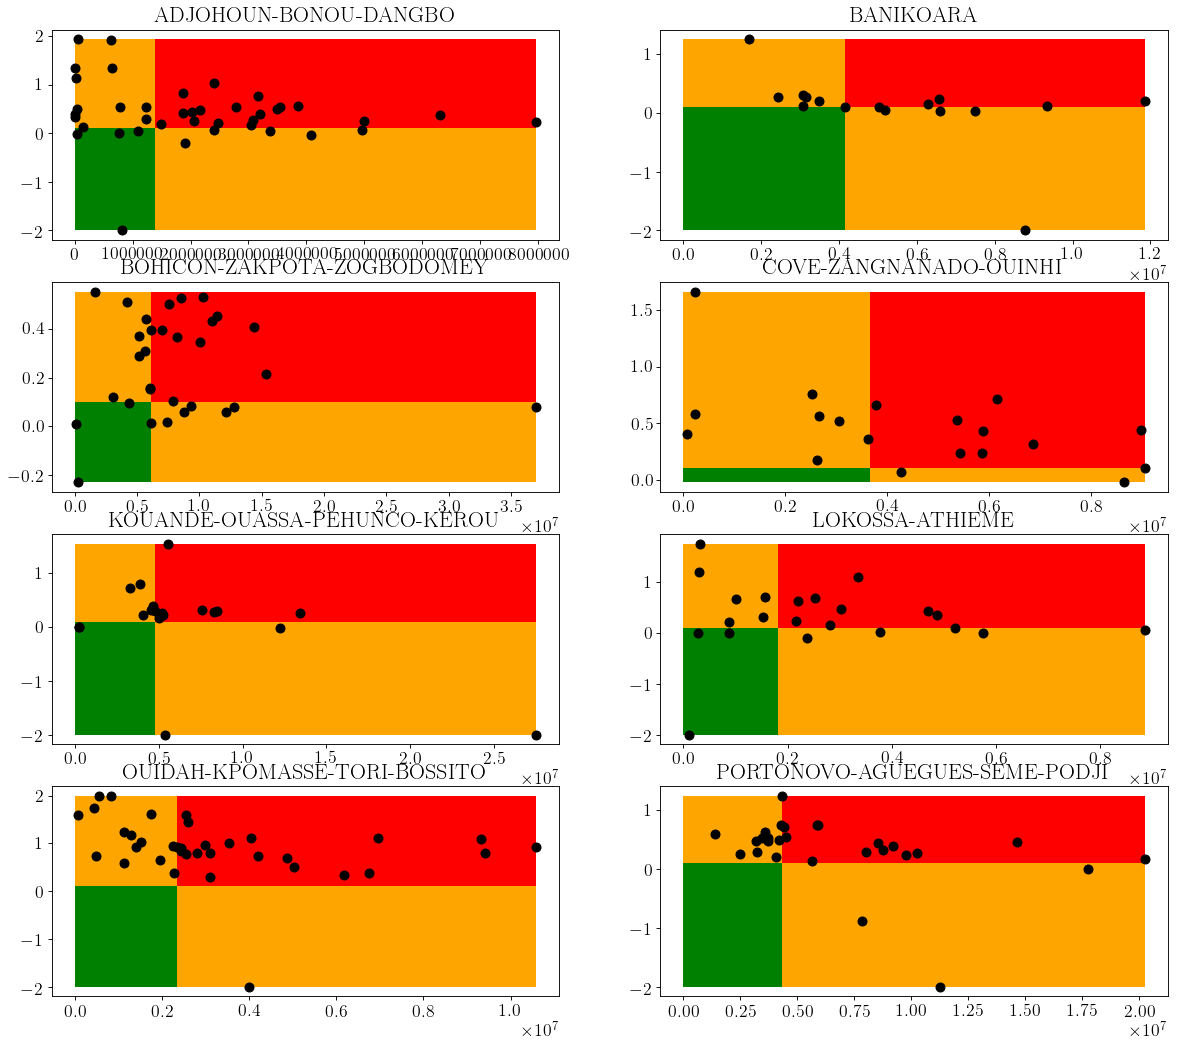

In [9]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(1,9):
    plt.subplot(4,2,i) 
    departement = list(ecart_moyen_pondere.index.levels[0])[i-1]
    make_cadran(ecart_moyen_pondere.loc[departement])
    plt.title(departement)

In [10]:
def classify_facilities(ecart_moyen_pondere):
    q4_rev = ecart_moyen_pondere['Montant'].quantile(0.4)
    ecart_moyen_pondere['Class'] = 'red'
    ecart_moyen_pondere.loc[(ecart_moyen_pondere['Montant'] <= q4_rev) &
                            (ecart_moyen_pondere['Ecart Moyen Pondéré'] <= 0.1) , 'Class'] = 'green' 
    ecart_moyen_pondere.loc[(ecart_moyen_pondere['Montant'] <= q4_rev) & 
                            (ecart_moyen_pondere['Ecart Moyen Pondéré'] > 0.1) , 'Class'] = 'orange'
    ecart_moyen_pondere.loc[(ecart_moyen_pondere['Montant'] > q4_rev) & 
                            (ecart_moyen_pondere['Ecart Moyen Pondéré'] <= 0.1), 'Class'] = 'orange'
    return ecart_moyen_pondere

In [11]:
classified_data = ecart_moyen_pondere.groupby(level = 0).apply(classify_facilities)
classes_counts = classified_data.groupby(level = 0).Class.value_counts()

In [12]:
def bar_cols(col_data , order_cols = ['green' , 'orange' , 'red']):
    o = []
    for col in order_cols:
        try :
            n = col_data.loc[col]
            o.append(n)
        except KeyError :
            o.append(0)
    
    plt.bar([0,1,2], o , color = order_cols)
    plt.xticks([0,1,2] , order_cols)

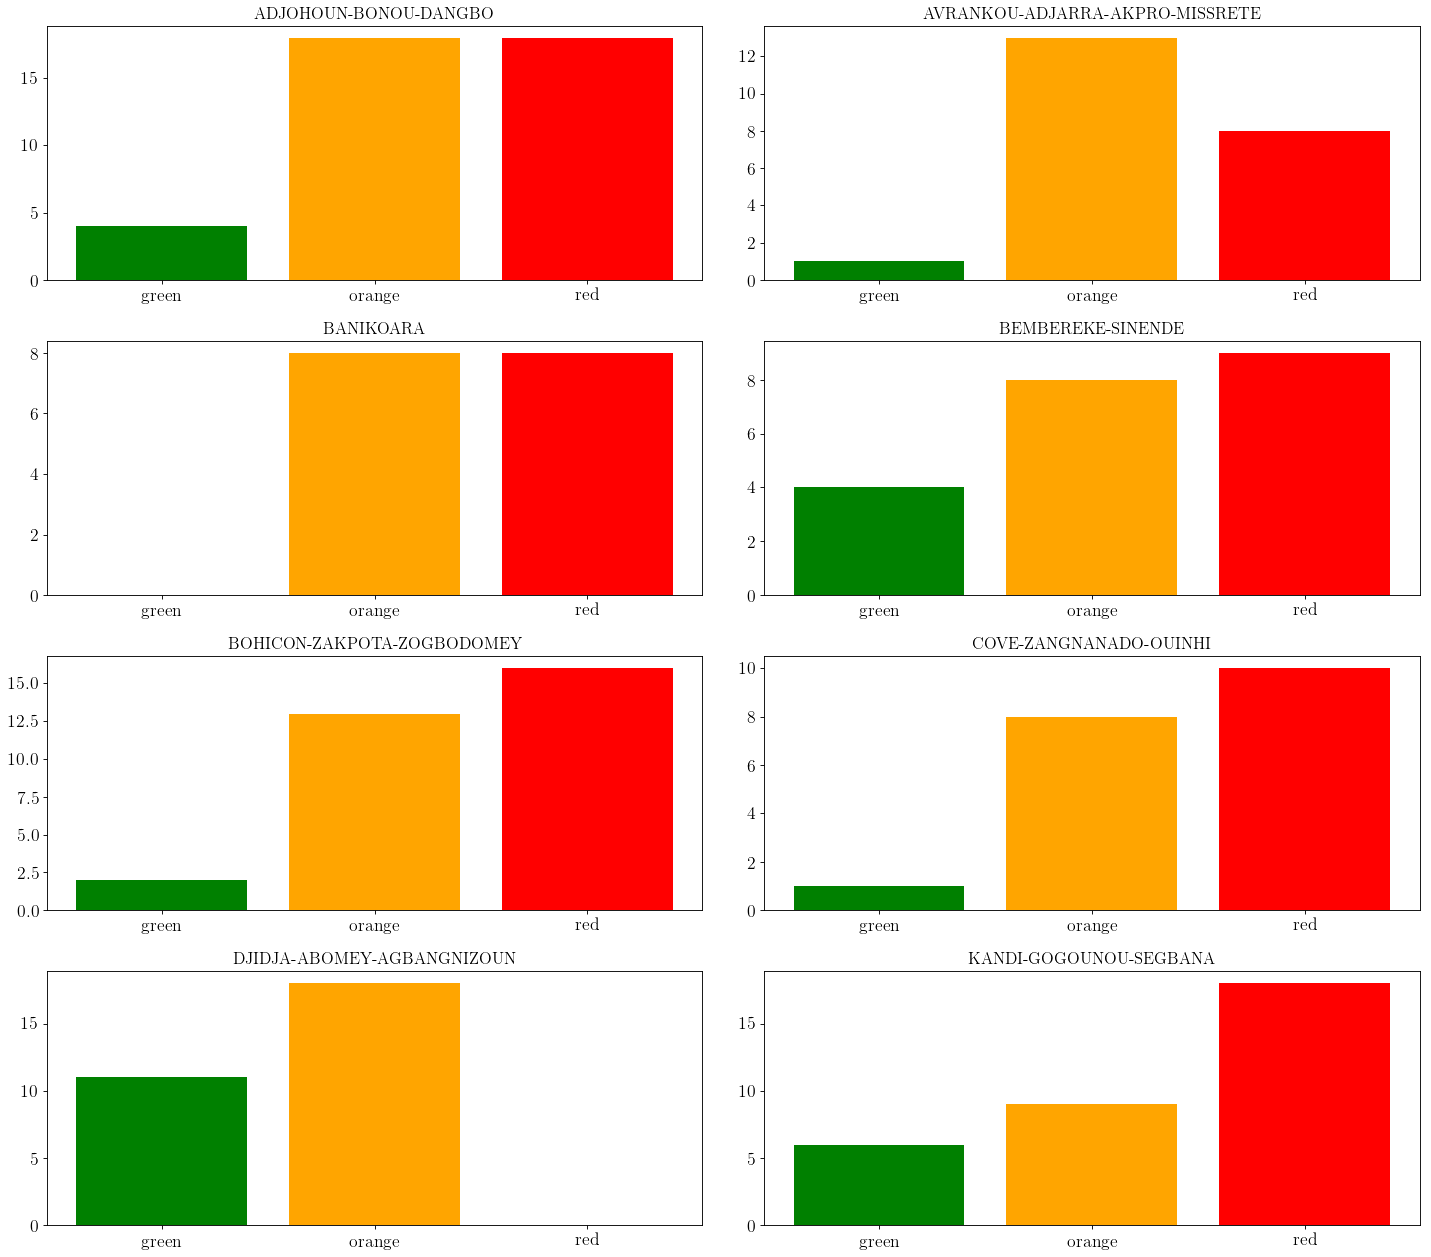

In [41]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(1,9):
    plt.subplot(4,2,i) 
    departement = list(classes_counts.index.levels[0])[i-1]
    bar_cols(classes_counts.loc[departement])
    plt.title(departement , fontsize=15)

## Routine implementation

In a second step, I impement a simple unique function to classify facilities. In a second step, I run this routine separately in each departement. The full routine takes less than 3 seconds to run.

In [14]:
def make_facilities_classification(data , ponderation , perc_risk):
    
    data['claimed_payment'] = list(data.indicator_claimed_value * data['indicator_tarif'])
    data['verified_payment'] = list(data.indicator_verified_value * data['indicator_tarif'])
    
    if sum(data['claimed_payment'] - data['verified_payment']) != 0 :
        data = data.set_index('indicator_label')
        table_1 = make_first_table(data)
    
        indicateurs_critiques = list(table_1[table_1['% Cumulé'] <= perc_risk].index)
    
        data_classif = data.loc[indicateurs_critiques]
        data_classif = data_classif.reset_index()
    
        ecart_moyen_pondere = data_classif.groupby(['entity_name']).apply(get_ecart_pondere , ponderation = ponderation)
        ecart_moyen_pondere = classify_facilities(ecart_moyen_pondere)
        return ecart_moyen_pondere

In [15]:
%%time
classified_facilities = data.groupby('geozone_name').apply(make_facilities_classification , 
                                                           ponderation = ponderation , 
                                                           perc_risk =  0.8)

Wall time: 3.21 s


In [16]:
classes_counts = classified_facilities.groupby(level = 0).Class.value_counts()

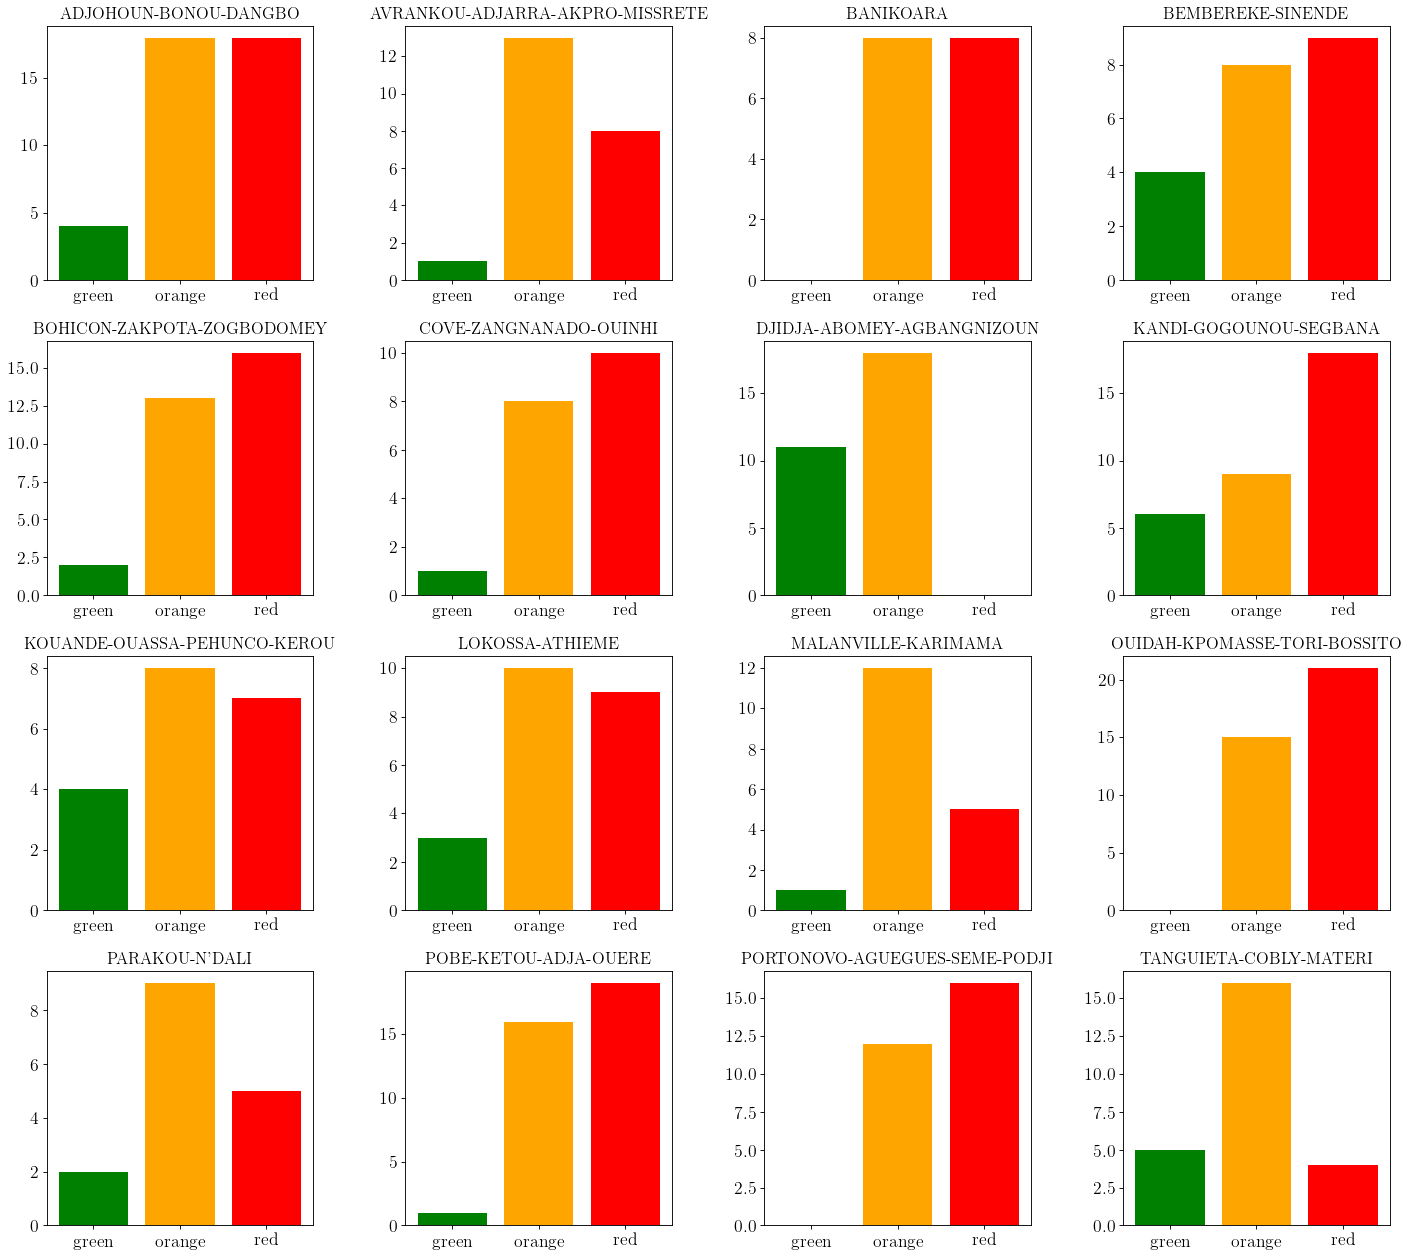

In [40]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(1,17):
    plt.subplot(4,4,i) 
    departement = list(classes_counts.index.levels[0])[i-1]
    bar_cols(classes_counts.loc[departement])
    departement =departement.replace('’' , "'")
    plt.title(departement , fontsize=15)